In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
import numpy as np
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.palettes import Pastel1
from bokeh.models import Span

<Axes: >

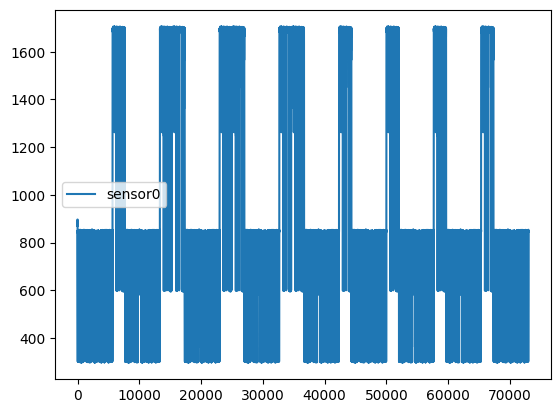

In [62]:
df_nodrift = pd.read_csv(r"C:\Users\franc\Desktop\TESI\training_info\sensors_data.csv")
df_drift = pd.read_csv(r"C:\Users\franc\Desktop\TESI\SML_thesis_line_follower_robot\tmp\e-puck\data\data\sensors_data\sensors_data_drift.csv")
for i in range(5):
    df = pd.concat([df,df_drift],ignore_index=True)
    df = pd.concat([df,df_nodrift],ignore_index=True)

df.plot(y='sensor0')


In [70]:
class DriftDetector:
    def __init__(self, nero, bianco, tol, min_duration, min_gap):
        self.nero = nero
        self.bianco = bianco
        self.tol = tol
        self.min_duration = min_duration
        self.min_gap = min_gap
        self.anomalies = []
        self.outlier_count = 0
        self.anomaly_start = None
        self.last_anomaly_end = -1
        self.current_index = 0
        self.last_notification = None
        self.drift_detected = False

    def update(self, value):
        is_outlier = (value < (self.nero - self.tol)) or ((value > (self.nero + self.tol)) and (value < (self.bianco - self.tol))) or (value > (self.bianco + self.tol))
        
        if is_outlier:
            self.outlier_count += 1
            if self.outlier_count == self.min_duration and self.anomaly_start is None:
                if self.current_index - self.min_duration + 1 <= self.last_anomaly_end + self.min_gap:
                    # Extend the previous anomaly
                    self.anomaly_start = self.anomalies[-1][0]
                    self.anomalies.pop()
                else:
                    self.anomaly_start = self.current_index - self.min_duration + 1
                    print(f"{self.current_index}: anomalia iniziata all'indice {self.anomaly_start}")
                    self.drift_detected = True
                self.last_notification = "start"
        else:
            if self.anomaly_start is not None:
                self.anomalies.append((self.anomaly_start, self.current_index - 1))
                self.last_anomaly_end = self.current_index - 1
                self.anomaly_start = None
                self.last_notification = "end"
            elif self.last_notification == "end" and self.current_index > self.last_anomaly_end + self.min_gap:
                print(f"{self.current_index}: anomalia terminata all'indice {self.last_anomaly_end}")
                self.last_notification = None
                self.drift_detected = False
            self.outlier_count = 0
        
        self.current_index += 1
        return self.drift_detected   
    
    def plot_anomalies(self,df):
        print("Anomalie rilevate (inizio, fine):", self.anomalies)

        plt.figure(figsize=(10, 5))
        plt.plot(df, label='sensor0')
        for start, end in self.anomalies:
            plt.axvspan(start, end, color='red', alpha=0.3, label='Anomaly' if start == self.anomalies[0][0] else '')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title('Sensor0 with Anomalies')
        plt.legend()
        plt.grid(True)
        plt.show()

5684: anomalia iniziata all'indice 5665
7690: anomalia terminata all'indice 7664
13349: anomalia iniziata all'indice 13330
17355: anomalia terminata all'indice 17329
23014: anomalia iniziata all'indice 22995
27020: anomalia terminata all'indice 26994
32679: anomalia iniziata all'indice 32660
36685: anomalia terminata all'indice 36659
42344: anomalia iniziata all'indice 42325
44350: anomalia terminata all'indice 44324
50009: anomalia iniziata all'indice 49990
52015: anomalia terminata all'indice 51989
57674: anomalia iniziata all'indice 57655
59680: anomalia terminata all'indice 59654
65339: anomalia iniziata all'indice 65320
67345: anomalia terminata all'indice 67319
Anomalie persistenti rilevate (inizio, fine): [(5665, 7664), (13330, 17329), (22995, 26994), (32660, 36659), (42325, 44324), (49990, 51989), (57655, 59654), (65320, 67319)]


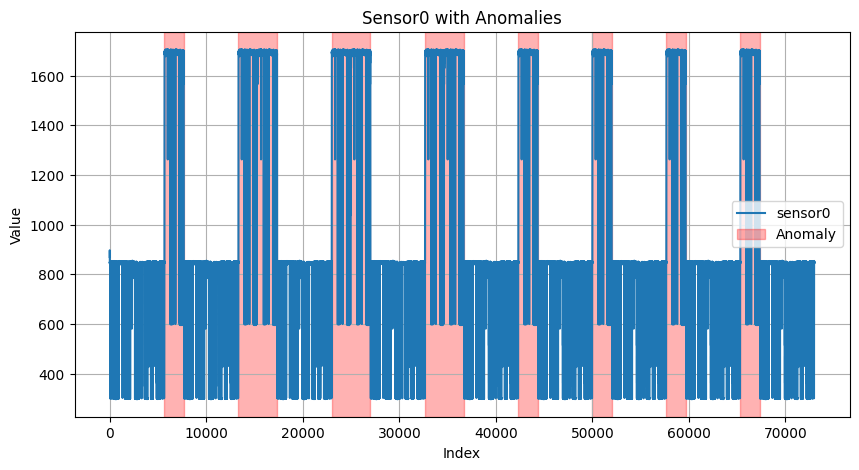

In [69]:
valore_nero = 300
valore_bianco = 850
tolleranza = 50
min_outlier_duration = 20
min_gap_duration = 25 

# Initalize the detector
detector = DriftDetector(valore_nero, valore_bianco, tolleranza, min_outlier_duration, min_gap_duration)


for i,value in enumerate(df['sensor0'].values):
    detector.update(value)
    
        
    
   
detector.plot_anomalies(df['sensor0'].values)